In [24]:
import torch
import torch.nn as nn
from torch.optim import SGD

import numpy as np
from numpy import dot
import matplotlib.pyplot as plt

In [25]:
class NeuralNet(nn.Module):
    def __init__(self, input_size, hidden_size, num_classes):
        super(NeuralNet, self).__init__()
        self.input_layer = nn.Linear(input_size, hidden_size)
        self.hidden = nn.Linear(hidden_size, hidden_size)
        self.output_layer = nn.Linear(hidden_size, num_classes)
    
    def forward(self, x):
        x=self.input_layer(x)
        x=x.relu()
        x=self.hidden(x)
        x=x.relu()
        x=self.output_layer(x)
        return x
    
def ReLU_glorot_init(model):
    for name, param in model.named_parameters():
        
        if name.endswith(".bias"):
            param.data.fill_(0)
        else:
            nn.init.xavier_normal_(param)

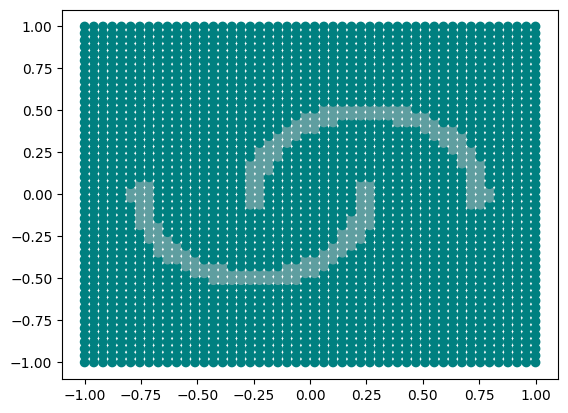

In [26]:
RES=50
X=[]
for x_1 in np.linspace(-1,1,RES):
    for x_2 in np.linspace(-1,1,RES):
        X.append([x_1,x_2])
X=np.array(X)

encode_inputs=lambda x: 1 if (abs((x[0]+0.25)**2+x[1]**2-0.25)<0.05 and x[1]<0.1) or (abs((x[0]-0.25)**2+x[1]**2-0.25)<0.05 and x[1]>-0.1) else 0
Y=np.array([encode_inputs(x) for x in X])

X=torch.from_numpy(X).float()
Y=torch.from_numpy(Y).float()


colors=np.full(len(Y), 'cadetblue')
colors[Y==0]='teal'

plt.scatter(X[:,0],X[:,1],c=colors)

In [27]:
def next_batch(inputs, targets, batchSize):
	for i in range(0, inputs.shape[0], batchSize):
		yield (inputs[i:i + batchSize], targets[i:i + batchSize])

BATCH_SIZE = 100
EPOCHS = 200
LR = 0.1



In [28]:
def stiffness_distance(epochs,learning_rate,batch_size,d):
    model = NeuralNet(2,64,2)
    ReLU_glorot_init(model)

    opt = SGD(model.parameters(), lr=learning_rate)
    lossFunc = nn.CrossEntropyLoss()

    def training():
        trainLoss = 0
        samples = 0
        for batchX, batchY in next_batch(X, Y, batch_size):
            predictions = model(batchX)
            loss = lossFunc(predictions, batchY.long())
            opt.zero_grad()
            loss.backward()
            opt.step()
            samples += len(batchY)
            trainLoss += loss.item()*len(batchY)
        return trainLoss/samples
    
    def get_gradients():
        grads=[]
        for x,y in zip(X,Y):
            predictions = model(x)
            loss = lossFunc(predictions, y.long())
            opt.zero_grad()
            loss.backward()
            gradient=[]
            gradient+=torch.flatten(model.input_layer.weight.grad).tolist()
            gradient+=model.input_layer.bias.grad.tolist()
            gradient+=torch.flatten(model.hidden.weight.grad).tolist()
            gradient+=model.hidden.bias.grad.tolist()
            gradient+=torch.flatten(model.output_layer.weight.grad).tolist()
            gradient+=model.output_layer.bias.grad.tolist()
            gradient=np.array(gradient)
            grad_norm=np.linalg.norm(gradient)
            if grad_norm!=0:
                gradient=gradient/np.linalg.norm(gradient)
            grads.append(gradient)


        dot_matrix=[]
        for i,x1 in enumerate(X):
            avg_dot=0
            samples=0
            for j,x2 in enumerate(X):
                if np.linalg.norm(x1-x2)<d and i!=j:        
                    avg_dot+=np.dot(grads[i],grads[j])
                    samples+=1
            if samples==0:
                dot_matrix.append(0)
            else:
                avg_dot=avg_dot/samples
                dot_matrix.append(avg_dot)
        return dot_matrix
    
    init_dot_matrix=get_gradients()
    
    for n in range(epochs):
        l=training()
        print('Epoch {}: Loss {:.3f}'.format(n+1,l))

    trained_dot_matrix=get_gradients()

    return init_dot_matrix, trained_dot_matrix

In [33]:
distances=[0.05,0.1,0.15]
distances_matrices=[]
for d in distances:
    init_matrix,trained_matrix=stiffness_distance(1000,0.1,50,d)
    distances_matrices.append([init_matrix,trained_matrix])

Epoch 1: Loss 0.340
Epoch 2: Loss 0.266
Epoch 3: Loss 0.263
Epoch 4: Loss 0.260
Epoch 5: Loss 0.258
Epoch 6: Loss 0.256
Epoch 7: Loss 0.253
Epoch 8: Loss 0.251
Epoch 9: Loss 0.249
Epoch 10: Loss 0.246
Epoch 11: Loss 0.244
Epoch 12: Loss 0.242
Epoch 13: Loss 0.241
Epoch 14: Loss 0.239
Epoch 15: Loss 0.237
Epoch 16: Loss 0.236
Epoch 17: Loss 0.234
Epoch 18: Loss 0.232
Epoch 19: Loss 0.231
Epoch 20: Loss 0.229
Epoch 21: Loss 0.228
Epoch 22: Loss 0.226
Epoch 23: Loss 0.225
Epoch 24: Loss 0.224
Epoch 25: Loss 0.223
Epoch 26: Loss 0.222
Epoch 27: Loss 0.220
Epoch 28: Loss 0.219
Epoch 29: Loss 0.218
Epoch 30: Loss 0.217
Epoch 31: Loss 0.216
Epoch 32: Loss 0.215
Epoch 33: Loss 0.214
Epoch 34: Loss 0.213
Epoch 35: Loss 0.213
Epoch 36: Loss 0.212
Epoch 37: Loss 0.211
Epoch 38: Loss 0.211
Epoch 39: Loss 0.210
Epoch 40: Loss 0.209
Epoch 41: Loss 0.209
Epoch 42: Loss 0.208
Epoch 43: Loss 0.207
Epoch 44: Loss 0.207
Epoch 45: Loss 0.206
Epoch 46: Loss 0.206
Epoch 47: Loss 0.205
Epoch 48: Loss 0.204
E

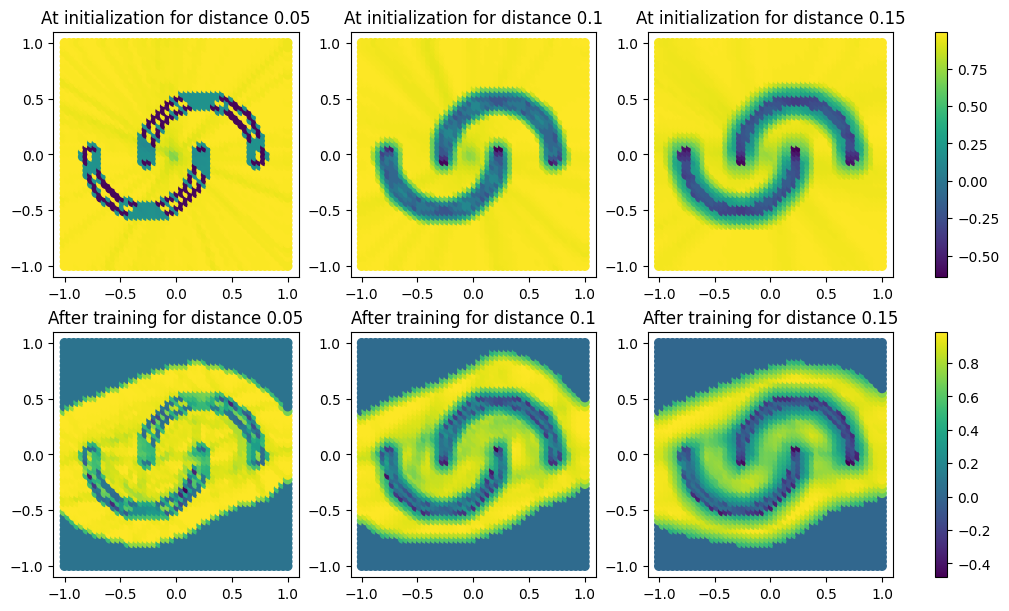

In [44]:
fig, axs = plt.subplots(2,len(distances), figsize=(10,6),layout='constrained')

for k, d in enumerate(distances):
    if k==len(distances)-1:
        pc0 = axs[0,k].scatter(X[:,0],X[:,1],c=distances_matrices[k][0])
    else:
        axs[0,k].scatter(X[:,0],X[:,1],c=distances_matrices[k][0])
    axs[0,k].set_title('At initialization for distance {}'.format(d))

    if k==len(distances)-1:
        pc1 = axs[1,k].scatter(X[:,0], X[:,1],c=distances_matrices[k][1])
    else:
        axs[1,k].scatter(X[:,0], X[:,1],c=distances_matrices[k][1])
    axs[1,k].set_title('After training for distance {}'.format(d))

fig.colorbar(pc0, ax=axs[0])
fig.colorbar(pc1, ax=axs[1])

plt.savefig('plots/Stiffness_Distance.png')